In [1]:
#Cell_1.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Cell_2.
mufj_csv="8316_2018.csv"
mufj=pd.read_csv(mufj_csv,skiprows=1,header=0,delimiter=',',encoding="shift-jis")
print(mufj.shape) #確認
print(mufj.head()) #確認
print(type(mufj['日付'][0]))
mufj['日付']=pd.to_datetime(mufj['日付'])
print(type(mufj['日付'][0]))

(105, 7)
           日付    始値    高値    安値    終値       出来高  終値調整値
0  2018-01-04  4949  5015  4946  5013   9066700   5013
1  2018-01-05  5071  5134  5067  5095  10985300   5095
2  2018-01-09  5190  5203  5078  5090   7822700   5090
3  2018-01-10  5182  5215  5168  5177   9731100   5177
4  2018-01-11  5230  5242  5178  5228   8621500   5228
<class 'str'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


データの初日を0日目としたときの日数と株価の回帰直線を求める  
まず日付の列をデータの初日を0日目としたときの日数に変換  

In [3]:
#Cell_3.
mufj_d=mufj.copy()
mufj_d['日付']-=mufj_d['日付'][0]
print(type(mufj_d['日付'][0]))
mufj_d['日付']/=np.timedelta64(1,'D')
print(type(mufj_d['日付'][0]))
print(mufj_d.head())

<class 'pandas._libs.tslibs.timedeltas.Timedelta'>
<class 'numpy.float64'>
    日付    始値    高値    安値    終値       出来高  終値調整値
0  0.0  4949  5015  4946  5013   9066700   5013
1  1.0  5071  5134  5067  5095  10985300   5095
2  5.0  5190  5203  5078  5090   7822700   5090
3  6.0  5182  5215  5168  5177   9731100   5177
4  7.0  5230  5242  5178  5228   8621500   5228


In [4]:
#Cell_4.
print(type(mufj_d))
mufj_d=np.asarray(mufj_d)
print(type(mufj_d))
print(mufj_d.shape)
X=mufj_d[:,:1]
Y=mufj_d[:,6]
print(X.shape)
print(Y.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
(105, 7)
(105, 1)
(105,)


回帰の計算

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     115.9
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           1.48e-18
Time:                        11:30:16   Log-Likelihood:                -690.71
No. Observations:                 105   AIC:                             1385.
Df Residuals:                     103   BIC:                             1391.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5012.4918     33.881    147.943      0.0

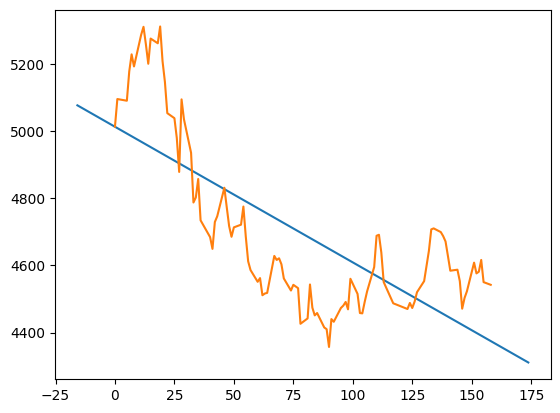

In [5]:
#Cell_5.
import statsmodels.api as sm

X=sm.add_constant(X)
model=sm.OLS(Y,X)
results=model.fit()
print(results.summary())
c=results.params[0]
a=results.params[1]
#print(mufj[:,0])
min_mufj=min(mufj_d[:,0])
max_mufj=max(mufj_d[:,0])
w_mufj=max_mufj-min_mufj
xx=np.linspace(min_mufj-0.1*w_mufj,max_mufj+0.1*w_mufj,20)
print(c,a)
#print(xx)
yy=c+a*xx
plt.plot(xx,yy)
plt.plot(mufj_d[:,0],Y)
plt.show()

半年後の株価の予測値を求める

In [6]:
#Cell_6.
print("prediction for half-year later:",c+a*(max_mufj+175))

prediction for half-year later: 3668.091718066933


（参考）他企業との相関を比較

In [7]:
#Cell_7.
import scipy.stats as ss

csv_list=[ '8306_2018.csv', '7936_2018.csv', '4661_2018.csv', '5332_2018.csv', '6501_2018.csv' ]
r_list=[]
#print(mufj.head()) #debug
for csv1 in csv_list:
    print(csv1)
    com=pd.read_csv(csv1,skiprows=1,header=0,delimiter=',',encoding="shift-jis")
    com['日付']=pd.to_datetime(com['日付'])
    print(com.shape) #確認
    #print(com.head()) #debug
    merged=pd.merge(mufj, com, on='日付', how='inner')
    print(merged.shape) #確認
    #print(merged.head()) #debug
    merged_date=merged['日付']
    merged_date=pd.to_datetime(merged_date) #str型からdatetime型に型変換
    merged_mufj=merged['終値調整値_x']
    merged_com=merged['終値調整値_y']
    r,p=ss.pearsonr(merged_mufj, merged_com)
    r_list.append(r)

print(r_list)

#相関係数が最大、最小、ゼロに最も近いものをみつける。
i_min=0
i_max=0
i_zero=0
for i in range(len(r_list)):
    if r_list[i]<r_list[i_min]:
        i_min=i
    if r_list[i]>r_list[i_max]:
        i_max=i
    if abs(r_list[i])<abs(r_list[i_zero]):
        i_zero=i

8306_2018.csv
(105, 7)
(105, 13)
7936_2018.csv
(120, 7)
(105, 13)
4661_2018.csv
(120, 7)
(105, 13)
5332_2018.csv
(120, 7)
(105, 13)
6501_2018.csv
(120, 7)
(105, 13)
[0.9573303071255435, -0.38472485087141434, -0.04157309445413357, 0.7340894009230414, 0.8866956970091981]


相関係数最大の企業との散布図とチャート重ね合わせ

In [8]:
#Cell_8.
com=pd.read_csv(csv_list[i_max],skiprows=1,header=0,delimiter=',',encoding="shift-jis")
com['日付']=pd.to_datetime(com['日付'])
merged=pd.merge(mufj, com, on='日付', how='inner')
merged_date=merged['日付']
merged_date=pd.to_datetime(merged_date) #str型からdatetime型に型変換
merged_mufj=merged['終値調整値_x']
merged_com=merged['終値調整値_y']
print(csv_list[i_max]+':', r_list[i_max])

8306_2018.csv: 0.9573303071255435


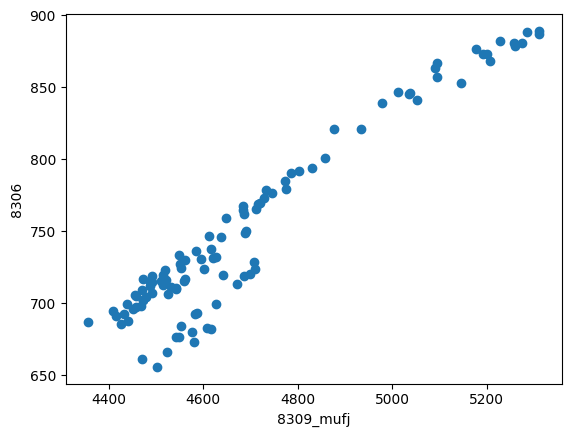

In [9]:
#Cell_9.
import re

plt.scatter(merged_mufj, merged_com)
plt.xlabel('8309_mufj')
com_label=re.sub(r'_2018[.]csv$', r'', csv_list[i_max])
plt.ylabel(com_label)
plt.show()

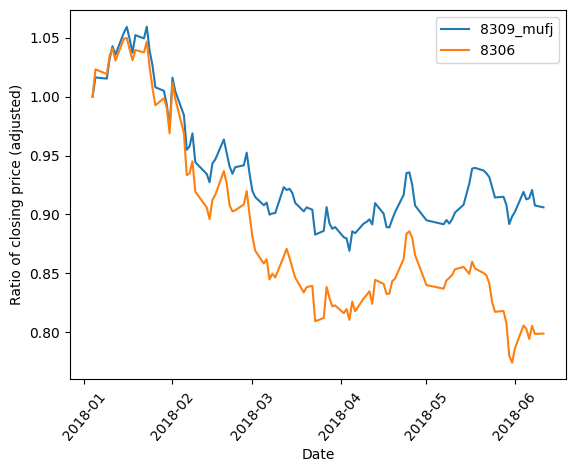

In [10]:
#Cell_10.
plt.plot(merged_date, merged_mufj/merged_mufj[0], label='8309_mufj')
plt.plot(merged_date, merged_com/merged_com[0], label=com_label)
plt.xlabel('Date')
plt.ylabel('Ratio of closing price (adjusted)')
plt.xticks(rotation=50)
plt.legend()
plt.show()

相関係数最大(負の相関であることを期待)の企業との散布図とチャート重ね合わせ

In [11]:
#Cell_11.
com=pd.read_csv(csv_list[i_min],skiprows=1,header=0,delimiter=',',encoding="shift-jis")
com['日付']=pd.to_datetime(com['日付'])
merged=pd.merge(mufj, com, on='日付', how='inner')
merged_date=merged['日付']
merged_date=pd.to_datetime(merged_date) #str型からdatetime型に型変換
merged_mufj=merged['終値調整値_x']
merged_com=merged['終値調整値_y']
print(csv_list[i_min]+':', r_list[i_min])

7936_2018.csv: -0.38472485087141434


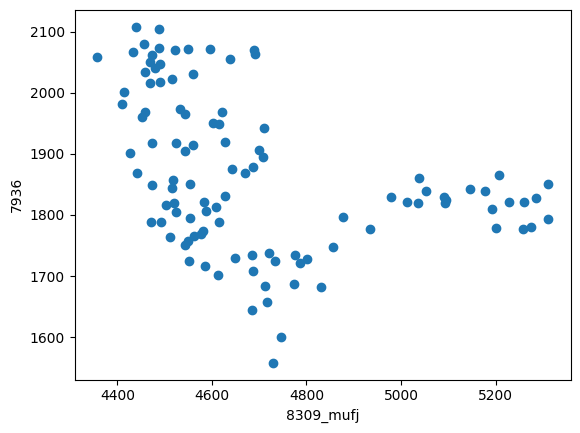

In [12]:
#Cell_12.
plt.scatter(merged_mufj, merged_com)
plt.xlabel('8309_mufj')
com_label=re.sub(r'_2018[.]csv$', r'', csv_list[i_min])
plt.ylabel(com_label)
plt.show()

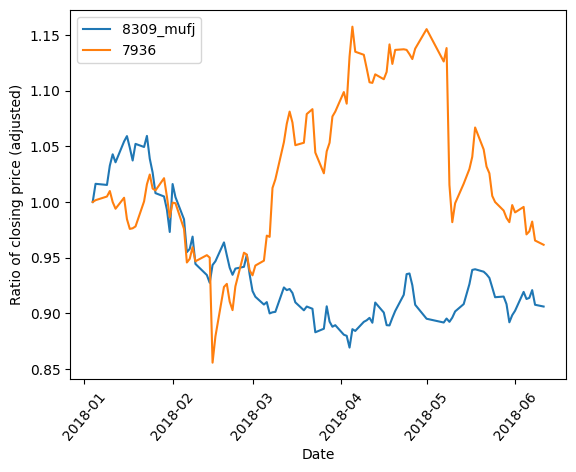

In [13]:
#Cell_13.
plt.plot(merged_date, merged_mufj/merged_mufj[0], label='8309_mufj')
plt.plot(merged_date, merged_com/merged_com[0], label=com_label)
plt.xlabel('Date')
plt.ylabel('Ratio of closing price (adjusted)')
plt.xticks(rotation=50)
plt.legend()
plt.show()

相関係数ゼロ付近の企業との散布図とチャート重ね合わせ

In [14]:
#Cell_14.
com=pd.read_csv(csv_list[i_zero],skiprows=1,header=0,delimiter=',',encoding="shift-jis")
com['日付']=pd.to_datetime(com['日付'])
merged=pd.merge(mufj, com, on='日付', how='inner')
merged_date=merged['日付']
merged_date=pd.to_datetime(merged_date) #str型からdatetime型に型変換
merged_mufj=merged['終値調整値_x']
merged_com=merged['終値調整値_y']
print(csv_list[i_zero]+':', r_list[i_zero])

4661_2018.csv: -0.04157309445413357


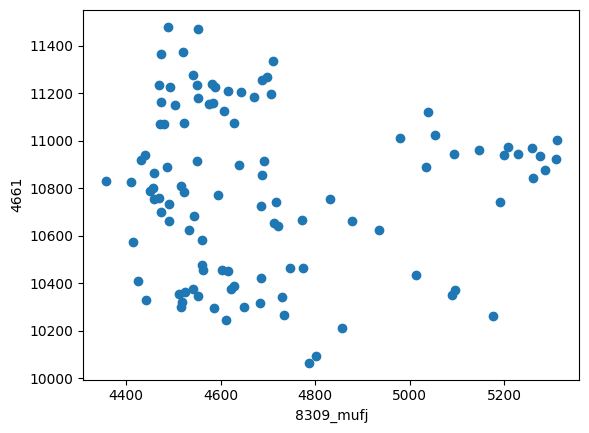

In [15]:
#Cell_15.
plt.scatter(merged_mufj, merged_com)
plt.xlabel('8309_mufj')
com_label=re.sub(r'_2018[.]csv$', r'', csv_list[i_zero])
plt.ylabel(com_label)
plt.show()

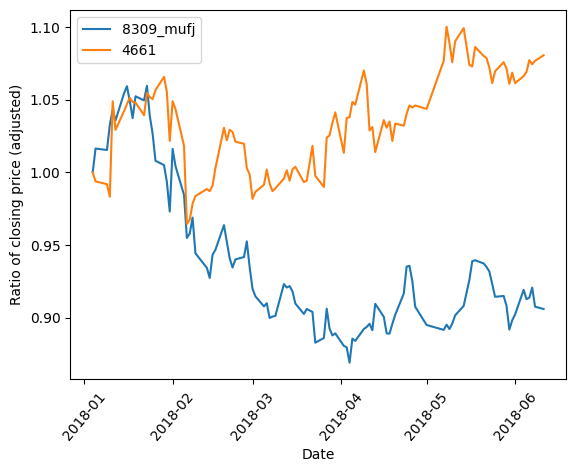

In [16]:
#Cell_16.
plt.plot(merged_date, merged_mufj/merged_mufj[0], label='8309_mufj')
plt.plot(merged_date, merged_com/merged_com[0], label=com_label)
plt.xlabel('Date')
plt.ylabel('Ratio of closing price (adjusted)')
plt.xticks(rotation=50)
plt.legend()
plt.show()